In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240523%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240523T090908Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D40ebf21c2352927760114af39df16e0ec483d02ca09aba83848b41f0e0b9472ec923ef8e33e6ca1be6ac01069d3d223a3043dad551e8da3ba40b59eac65a7b1d3721cc7b55f648d3ae76238a5beb2e1e5a3dfc9bcd63329b99ad08b9f574b826b7ce02b986a6516f4ee612f6fccc36e3c3ba61d358ae3c2e1cf3314f6d45abe7328646113dbe1199cd02d76ee37dfa5e810202aaf29fb8ca128c761810d4c0bae3059d1c5cc26c3bb0cd408f16a9bfb4bccb370201e4daf8293a34752b61fe16dca25247e0943cc69e121d046d6ffc0669053b9ff597dfa6a61b5646323a46da910c6b34a8d760b251cc5ef7a51750aca96bb3858c51a5a7f9b307aad61c2588'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from PIL import Image

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input



In [3]:
BASE_DIR = '../input/utkface-new/UTKFace/'

In [4]:
import os
from tqdm import tqdm

# Define the base directory
BASE_DIR = '../input/utkface-new/UTKFace/'

# List all filenames in the directory
filenames = os.listdir(BASE_DIR)

# Using list comprehensions to extract image paths, ages, and genders
image_paths = [os.path.join(BASE_DIR, filename) for filename in tqdm(filenames)]
age_labels = [int(filename.split('_')[0]) for filename in tqdm(filenames)]
gender_labels = [int(filename.split('_')[1]) for filename in tqdm(filenames)]

# Print some basic information
print(f"Number of images: {len(image_paths)}")
print(f"Number of age labels: {len(age_labels)}")
print(f"Number of gender labels: {len(gender_labels)}")


100%|██████████| 23708/23708 [00:00<00:00, 1513777.94it/s]

Number of images: 23708
Number of age labels: 23708
Number of gender labels: 23708


In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/22_1_3_2017010500...,22,1
1,../input/utkface-new/UTKFace/28_0_0_2017012022...,28,0
2,../input/utkface-new/UTKFace/13_1_1_2017010920...,13,1
3,../input/utkface-new/UTKFace/28_1_0_2017011718...,28,1
4,../input/utkface-new/UTKFace/25_1_2_2017011600...,25,1


EXPLORATORY DATA ANALYSIS

In [6]:
df.describe()

,age,gender
count,23708.000000,23708.000000
mean,33.303484,0.477349
std,19.886112,0.499497
min,1.000000,0.000000
25%,23.000000,0.000000
50%,29.000000,0.000000
75%,45.000000,1.000000
max,116.000000,1.000000


<Axes: xlabel='age', ylabel='Count'>

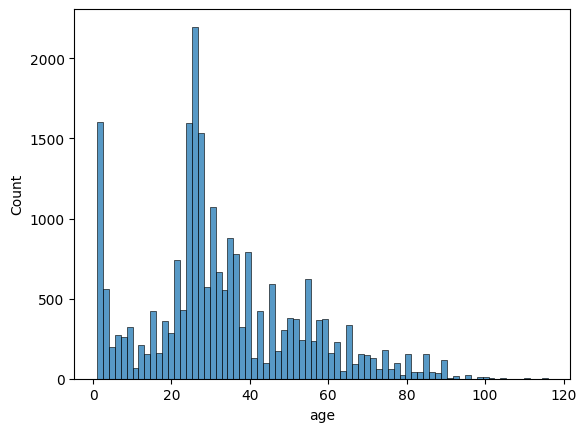

In [7]:
sns.histplot(df['age'])

In [8]:
print(df.isnull().sum())

image     0
age       0
gender    0
dtype: int64


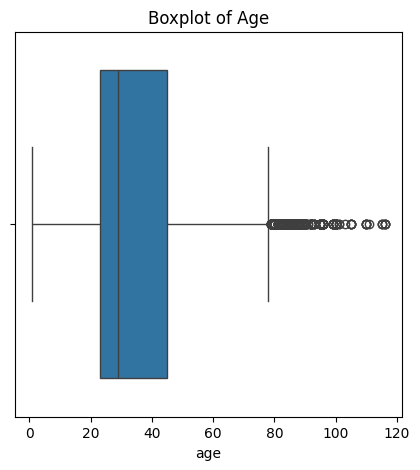

In [9]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='age', data=df)
plt.title('Boxplot of Age')
plt.show()

In [10]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

In [11]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


df_no_outliers = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]


num_outliers_removed = len(df) - len(df_no_outliers)
print(f"Number of outliers removed: {num_outliers_removed}")

Number of outliers removed: 696


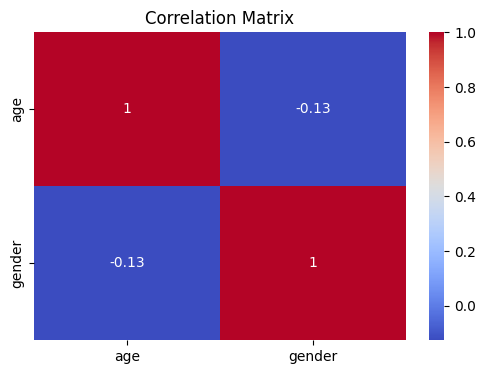

In [12]:
# Correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(df[['age', 'gender']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


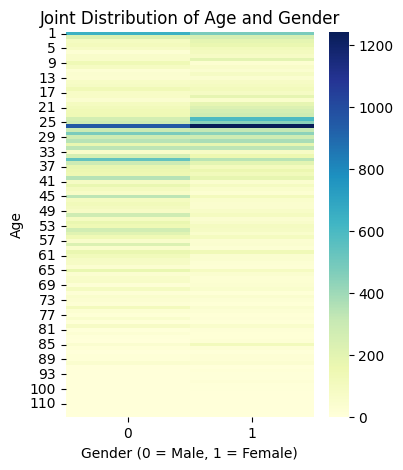

In [13]:
# Joint distribution of age and gender
age_gender_pivot = df.pivot_table(index='age', columns='gender', aggfunc='size', fill_value=0)
plt.figure(figsize=(4, 5))
sns.heatmap(age_gender_pivot, cmap="YlGnBu", annot=False)
plt.title('Joint Distribution of Age and Gender')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Age')
plt.show()


In [14]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [18]:
X = extract_features(df['image'])

100%|██████████| 23708/23708 [00:24<00:00, 973.56it/s] 


In [16]:
X.shape

(23708, 128, 128, 1)

In [17]:
# normalize the images
X = X/255.0

In [19]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])


In [33]:
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    X, y_age, y_gender, test_size=0.2, random_state=42)

In [43]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = (128, 128, 1)
inputs = Input(input_shape)
x = inputs

# Convolutional layers
filters = [32, 64, 128, 256]
for f in filters:
    x = Conv2D(f, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten layer
x = Flatten()(x)

# Fully connected layers with dropout
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

# Output layers
gender_out = Dense(1, activation='sigmoid', name='gender_out')(x)
age_out = Dense(1, activation='relu', name='age_out')(x)


In [46]:
model = Model(inputs=inputs, outputs=[gender_out, age_out])

# Compile model
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [47]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=25, validation_split=0.2)

Epoch 1/25
593/593 [==============================] - 14s 20ms/step - loss: 15.5595 - gender_out_loss: 0.8132 - age_out_loss: 14.7463 - gender_out_accuracy: 0.6258 - gender_out_mae: 0.4248 - age_out_accuracy: 0.0448 - age_out_mae: 14.7463 - val_loss: 11.0311 - val_gender_out_loss: 0.5405 - val_age_out_loss: 10.4907 - val_gender_out_accuracy: 0.7436 - val_gender_out_mae: 0.3898 - val_age_out_accuracy: 0.0335 - val_age_out_mae: 10.4907
Epoch 2/25
593/593 [==============================] - 11s 19ms/step - loss: 11.5145 - gender_out_loss: 0.5793 - age_out_loss: 10.9351 - gender_out_accuracy: 0.6981 - gender_out_mae: 0.3825 - age_out_accuracy: 0.0368 - age_out_mae: 10.9351 - val_loss: 9.6783 - val_gender_out_loss: 0.5394 - val_age_out_loss: 9.1389 - val_gender_out_accuracy: 0.7204 - val_gender_out_mae: 0.3718 - val_age_out_accuracy: 0.0403 - val_age_out_mae: 9.1389
Epoch 3/25
593/593 [==============================] - 12s 20ms/step - loss: 10.4686 - gender_out_loss: 0.5512 - age_out_loss: 9

In [52]:
print(history.history.keys())


dict_keys(['loss', 'gender_out_loss', 'age_out_loss', 'gender_out_accuracy', 'gender_out_mae', 'age_out_accuracy', 'age_out_mae', 'val_loss', 'val_gender_out_loss', 'val_age_out_loss', 'val_gender_out_accuracy', 'val_gender_out_mae', 'val_age_out_accuracy', 'val_age_out_mae'])


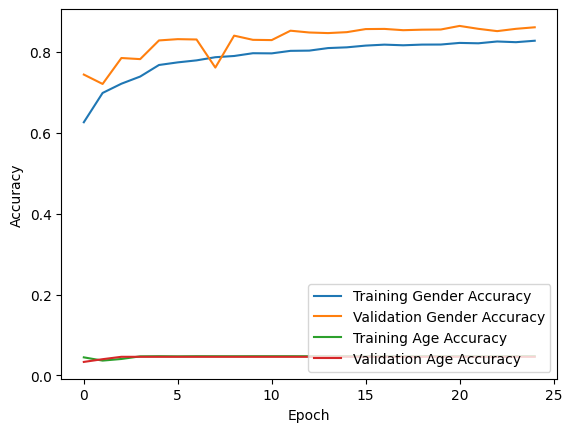

In [53]:
# Plot accuracy graph
plt.plot(history.history['gender_out_accuracy'], label='Training Gender Accuracy')
plt.plot(history.history['val_gender_out_accuracy'], label='Validation Gender Accuracy')
plt.plot(history.history['age_out_accuracy'], label='Training Age Accuracy')
plt.plot(history.history['val_age_out_accuracy'], label='Validation Age Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


Original Gender: Female Original Age: 24
1/1 [==============================] - 0s 45ms/step
Predicted Gender: Female Predicted Age: 31


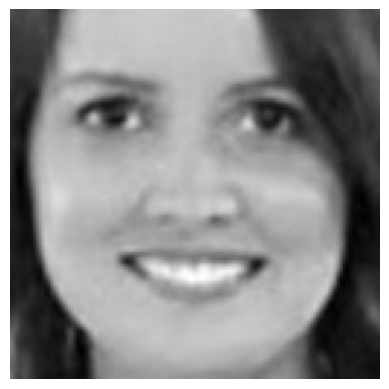

In [59]:
# Specify the index of the image you want to evaluate
gender_dict = {0: 'Male', 1: 'Female'}
image_index = 500

# Print the original gender and age labels
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# Predict from the model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

# Print the predicted gender and age labels
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Display the image
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
